In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Aug  1 12:21:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install transformers

In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.nn.functional as F
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import sklearn.utils
import time
import re
from google.colab import runtime

In [6]:
# Retrive the data from stored dataset
dataDir = "/content/drive/MyDrive/WoS/data/46985"
tsvData = os.path.join(dataDir,"WoSDataset_46985.tsv")

tsvData = np.loadtxt(tsvData, dtype=str, delimiter="\t")
print(np.shape(tsvData))

(46985, 4)


In [7]:
print(tsvData[0:10])

[['0' 'CS'
  ' 21dimensional nonlinear optical waves erbiumdoped optical fibre symbolic computation soliton solution soliton interaction        '
  '2  1dimensional nonlinear optical waves through the coherently excited resonant medium doped with the erbium atoms can be described by a 2  1dimensional nonlinear schrodinger equation coupled with the selfinduced transparency equations for such a system via the hirota method and symbolic computation linear forms one twoand nsoliton solutions are obtained asymptotic analysis is conducted and suggests that the interaction between the two solitons is elastic bright solitons are obtained for the fields e and p while the dark ones for the field n with e as the electric field p as the polarization in the resonant medium induced by the electric field and n as the population inversion profile of the dopant atoms headon interaction between the bidirectional two solitons and overtaking interaction between the unidirectional two solitons are seen inf

In [8]:
allLabels = tsvData[:,0]
domains = tsvData[:,1]
keywords = tsvData[:,2]
abstracts = tsvData[:,3]

In [9]:
labels = np.unique(domains, return_counts=True)[0]
labelCounts=  np.unique(domains, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [ 6514  4237  5483  3297 14625  7142  5687]


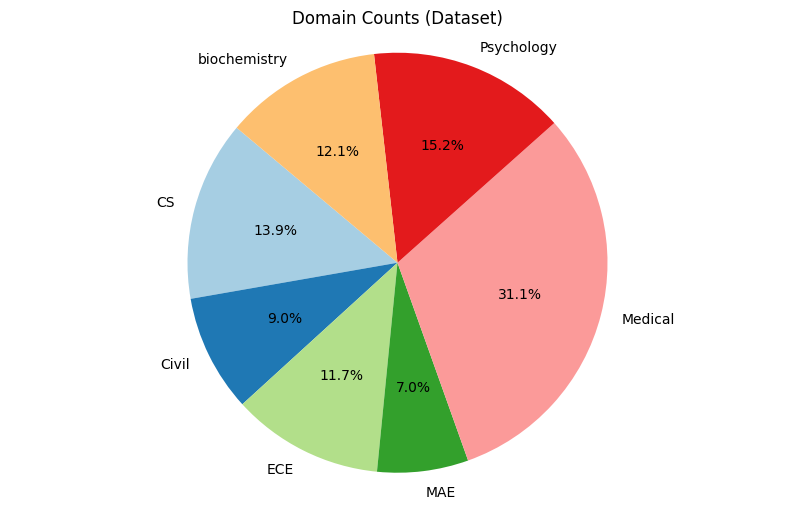

The domain CS has 6514 records in the dataset.
The domain Civil has 4237 records in the dataset.
The domain ECE has 5483 records in the dataset.
The domain MAE has 3297 records in the dataset.
The domain Medical has 14625 records in the dataset.
The domain Psychology has 7142 records in the dataset.
The domain biochemistry has 5687 records in the dataset.


In [10]:
# Visualize domain counts in dataset
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the dataset.")

In [11]:
# Shuffle data
dataShuffled = sklearn.utils.shuffle(tsvData)

abstractsShuffled = dataShuffled[:,3]
keywordsShuffled = dataShuffled[:,2]
domainsShuffled = dataShuffled[:,1]
allLabelsShuffled = dataShuffled[:,0]

print("Number of abstracts: ", len(abstractsShuffled))
print("Shape of abstracts: ", np.shape(abstractsShuffled))
print(abstractsShuffled[0:2])

print("Number of keywords: ", len(keywordsShuffled))
print("Shape of keywords: ", np.shape(keywordsShuffled))
print(abstractsShuffled[0:2])

print("Number of domains: ", len(domainsShuffled))
print("Shape of domains: ", np.shape(domainsShuffled))
print(domainsShuffled[0:2])

print("Number of labels: ", len(allLabelsShuffled))
print("Shape of labels: ", np.shape(allLabelsShuffled))
print(allLabelsShuffled[0:2])


# Convert labels to integer
allLabelsDigitShuffled = allLabelsShuffled.astype(int)

print(abstractsShuffled[0:10])
print(keywordsShuffled[0:10])
print(domainsShuffled[0:10])
print(allLabelsShuffled[0:10])
print(allLabelsDigitShuffled[0:10])

Number of abstracts:  46985
Shape of abstracts:  (46985,)
['recurrent pneumonia with cavitation leading to pneumatoceles secondary fungal infections and hemoptysis are major causes of mortality and morbidity in patients with hyperige syndrome prevention and aggressive treatment of pneumonia in these patients are essential to prevent further lung damage but treatment may be delayed because the classic signssymptoms of infection such as fever chills or rigors may be lacking early imaging to identify infection is essential for diagnosis and treatment the mainstay of therapy is continuous fulldose daily trimethoprimsulfamethoxazole and commonly fungal coverage because hyperige syndrome is a progressive disease patients condition may worsen despite compliance with prophylactic therapy c 2016 american academy of allergy asthma  immunology'
 'chronic inflammation can be caused by adaptive immune responses in autoimmune and allergic conditions driven by a t lymphocyte subset balance th1 th2 th

In [12]:
# Split dataset into training and testing (80/20 split)
train_data, test_data = train_test_split(dataShuffled, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))

# Further split training data into training and validation (80/20 split of training set)
_, val_data = train_test_split(test_data, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))
# Load SciBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

(37588, 4)
(9397, 4)
(37588, 4)
(9397, 4)
(1880, 4)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:
abstractsTrain = train_data[:,3]
keywordsTrain = train_data[:,2]
domainsTrain = train_data[:,1]
allLabelsTrain = train_data[:,0]

print("Number of abstracts: ",len(abstractsTrain))
print("Shape of abstracts: ",np.shape(abstractsTrain))
print("Number of keywords: ",len(keywordsTrain))
print("Shape of keywords: ",np.shape(keywordsTrain))
print("Number of domains: ",len(domainsTrain))
print("Shape of domains: ",np.shape(domainsTrain))
print("Number of labels: ",len(allLabelsTrain))
print("Shape of labels: ",np.shape(allLabelsTrain))

print(abstractsTrain[0:2])
print(keywordsTrain[0:2])
print(domainsTrain[0:2])
print(allLabelsTrain[0:2])

Number of abstracts:  37588
Shape of abstracts:  (37588,)
Number of keywords:  37588
Shape of keywords:  (37588,)
Number of domains:  37588
Shape of domains:  (37588,)
Number of labels:  37588
Shape of labels:  (37588,)
['game designers have to deal with the complex task of monitoring the emotional state of players in games there are different elements with the game which effect the players emotional status since the game play experience occurs almost unconsciously traditional methods such as think aloud may disrupt the playing experience thus skewing the results obtained other methods include fitting cables and electrodes to the player to monitor biological information although such devices can offer significant accurate results they are not commonly found and may cause discomfort while playing games because of this we propose a webcambased heart rate monitoring method that can be used to predict the players emotional state we first analyzed the change in heart rate with respect to th

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [ 5219  3402  4362  2647 11707  5708  4543]


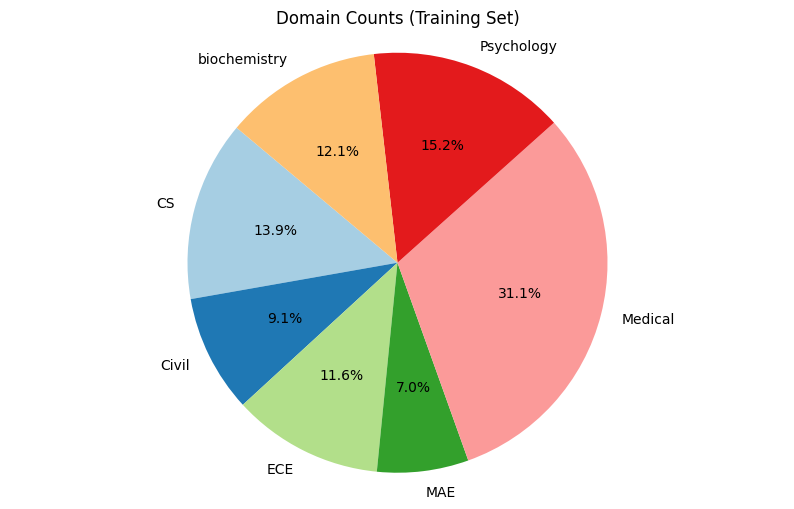

The domain CS has 5219 records in the training set.
The domain Civil has 3402 records in the training set.
The domain ECE has 4362 records in the training set.
The domain MAE has 2647 records in the training set.
The domain Medical has 11707 records in the training set.
The domain Psychology has 5708 records in the training set.
The domain biochemistry has 4543 records in the training set.


In [14]:
labels = np.unique(domainsTrain, return_counts=True)[0]
labelCounts =  np.unique(domainsTrain, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTrain)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Training Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the training set.")

In [15]:
abstractsTest = test_data[:,3]
keywordsTest = test_data[:,2]
domainsTest = test_data[:,1]
allLabelsTest = test_data[:,0]

print("Number of abstracts: ",len(abstractsTest))
print("Shape of abstracts: ",np.shape(abstractsTest))
print("Number of keywords: ",len(keywordsTest))
print("Shape of keywords: ",np.shape(keywordsTest))
print("Number of domains: ",len(domainsTest))
print("Shape of domains: ",np.shape(domainsTest))
print("Number of labels: ",len(allLabelsTest))
print("Shape of labels: ",np.shape(allLabelsTest))

# arr = np.array(domainsTest)
# cleaned_domains = np.char.strip(arr)
# print("Cleaned arr ", cleaned_domains)
# domainsLabelsTest = cleaned_domains
# print("Labels domains ", domainsLabelsTest)

print(abstractsTest[0:2])
print(keywordsTest[0:2])
print(domainsTest[0:2])
print(allLabelsTest[0:2])

Number of abstracts:  9397
Shape of abstracts:  (9397,)
Number of keywords:  9397
Shape of keywords:  (9397,)
Number of domains:  9397
Shape of domains:  (9397,)
Number of labels:  9397
Shape of labels:  (9397,)
['the microbiome located within a given host and its organs foinis a holobiont an intimate functional entity with evolutionarily designed interactions to support nutritional intake and reproduction thus all organs in a holobiont respond to changes within the microbiome the development and function of the central nervous system and its homeostatic mechanisms arc no exception and arc also subject to regulation by the gut microbiome in order for the holobiont to function effectively the microbiome and host must communicate the aryl hydrocarbon receptor is an evolutionarily conserved receptor recognizing environmental compounds including a number of ligands produced directly and indirectly by the microbiome this review focuses on the microbiomegutbrain axis in regard to the aryl hy

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [1295  835 1121  650 2918 1434 1144]


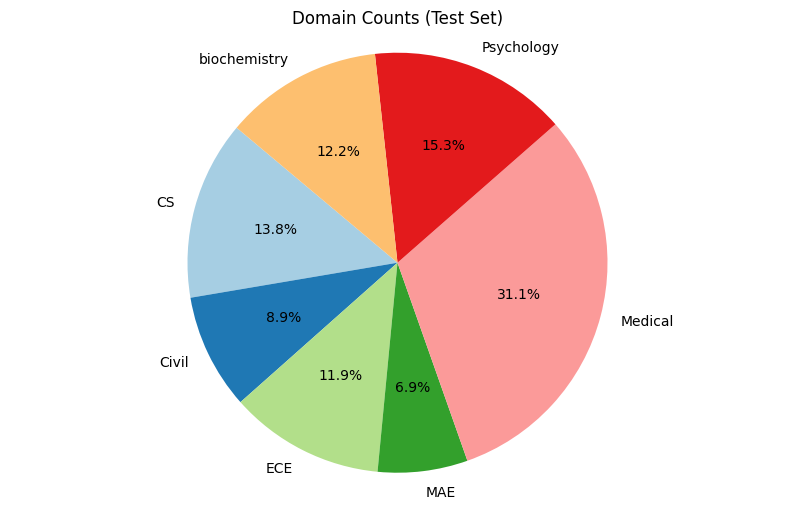

The domain CS has 1295 records in the test set.
The domain Civil has 835 records in the test set.
The domain ECE has 1121 records in the test set.
The domain MAE has 650 records in the test set.
The domain Medical has 2918 records in the test set.
The domain Psychology has 1434 records in the test set.
The domain biochemistry has 1144 records in the test set.


In [16]:
labels = np.unique(domainsTest, return_counts=True)[0]
labelCounts =  np.unique(domainsTest, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTest)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Test Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the test set.")

In [17]:
abstractsVal = val_data[:,3]
keywordsVal = val_data[:,2]
domainsVal = val_data[:,1]
allLabelsVal = val_data[:,0]

print("Number of abstracts: ",len(abstractsVal))
print("Shape of abstracts: ",np.shape(abstractsVal))
print("Number of keywords: ",len(keywordsVal))
print("Shape of keywords: ",np.shape(keywordsVal))
print("Number of domains: ",len(domainsVal))
print("Shape of domains: ",np.shape(domainsVal))
print("Number of labels: ",len(allLabelsVal))
print("Shape of labels: ",np.shape(allLabelsVal))

print(abstractsVal[0:2])
print(keywordsVal[0:2])
print(domainsVal[0:2])
print(allLabelsVal[0:2])

Number of abstracts:  1880
Shape of abstracts:  (1880,)
Number of keywords:  1880
Shape of keywords:  (1880,)
Number of domains:  1880
Shape of domains:  (1880,)
Number of labels:  1880
Shape of labels:  (1880,)
['rainwater harvesting in small dams has good potential to provide supplementary agricultural irrigation during critical crop growth stages field experiments were conducted to evaluate cropping patterns fallowwheat fw mashwheat maw sorghumwheat sw maize grainwheat mw maize graingram mg and mungcanola muc under two conditions irrigated command area of pira fatehial small dam and rainfed uncommand area on sandy loam soil during three years 2009 to 2011 treatments were arranged in a randomized complete block design three factor factorial cropping patterns irrigatednonirrigated conditions and years using four replications the highest grain yield of wheat 56mgha1 was obtained from the maw cropping pattern as compared to those from mw fw and sw cropping patterns summer crops sorghum 

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [270 159 207 131 576 310 227]


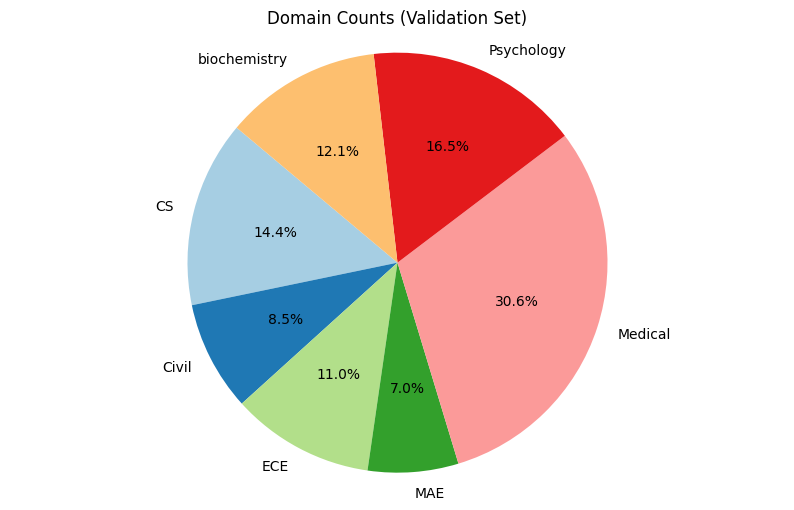

The domain CS has 270 records in the vaidation set.
The domain Civil has 159 records in the vaidation set.
The domain ECE has 207 records in the vaidation set.
The domain MAE has 131 records in the vaidation set.
The domain Medical has 576 records in the vaidation set.
The domain Psychology has 310 records in the vaidation set.
The domain biochemistry has 227 records in the vaidation set.


In [18]:
labels = np.unique(domainsVal, return_counts=True)[0]
labelCounts =  np.unique(domainsVal, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsVal)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Validation Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the vaidation set.")

In [19]:
# Function to tokenize and encode the dataset
def encode_data(data, tokenizer, max_length=128):
    # print(len(data[:,2]))
    inputs = tokenizer(
        data[:,2].tolist(), # Keywords 2
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )
    # print(len(dataShuffled[:, 0]))
    labels = torch.tensor(data[:, 0].astype(int))
    print("Label length ", len(labels))
    return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

In [20]:
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))


(37588, 4)
(9397, 4)
(1880, 4)


In [21]:
# Encode training, validation, and testing data
train_dataset = encode_data(train_data, tokenizer)
val_dataset = encode_data(val_data, tokenizer)
test_dataset = encode_data(test_data, tokenizer)



# Data loaders
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

Label length  37588
Label length  1880
Label length  9397


In [22]:
# Load SciBERT model
print(len(np.unique(train_data[:,0])))
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(np.unique(train_data[:,0])))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

7


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [23]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [24]:
# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 20
num_warmup_steps = 1e-4
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
def calculate_metrics(valType, predictions, true_labels):
    # Confusion matrix
    if(valType == 'test'):
        cm = confusion_matrix(true_labels, predictions)
        print("Confusion Matrix:\n", cm)

        # Classification report (includes precision, recall, F1 score)
        report = classification_report(true_labels, predictions, target_names=[str(i) for i in range(len(np.unique(true_labels)))])
        print("\nClassification Report:\n", report)

        # Calculate different types of F1 scores, precision, and recall
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')

        print(f"Macro F1 Score: {f1_macro}")
        print(f"Micro F1 Score: {f1_micro}")
        print(f"Weighted F1 Score: {f1_weighted}")

        print(f"Macro Precision: {precision_macro}")
        print(f"Micro Precision: {precision_micro}")
        print(f"Weighted Precision: {precision_weighted}")

        print(f"Macro Recall: {recall_macro}")
        print(f"Micro Recall: {recall_micro}")
        print(f"Weighted Recall: {recall_weighted}")

    elif(valType == 'val'):
        cm = confusion_matrix(true_labels, predictions)
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')
        # print('Val Micro F1:', f1_micro)
        return f1_micro

In [26]:
epochs = 20
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    start_time = time.time()

    # Training
    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch


        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=input_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    predictions = []
    true_labels = []

    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=input_mask)
            logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        batch_predictions = np.argmax(logits, axis=1)
        predictions.extend(batch_predictions)
        true_labels.extend(label_ids)

    val_micro_f1 = calculate_metrics('val', predictions, true_labels)
    elapsed_time = time.time() - start_time

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"  Train Loss: {avg_train_loss}")
    print(f"  Val Micro F1: {val_micro_f1}")
    print(f"  Time: {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

Epoch 1/20: 100%|██████████| 1175/1175 [11:50<00:00,  1.65batch/s]


Epoch 1/20
  Train Loss: 0.7736386025712845
  Val Micro F1: 0.7861702127659576
  Time: 12m 3s


Epoch 2/20: 100%|██████████| 1175/1175 [12:04<00:00,  1.62batch/s]


Epoch 2/20
  Train Loss: 0.5382143141297584
  Val Micro F1: 0.800531914893617
  Time: 12m 17s


Epoch 3/20: 100%|██████████| 1175/1175 [12:04<00:00,  1.62batch/s]


Epoch 3/20
  Train Loss: 0.41992990274378594
  Val Micro F1: 0.8010638297872339
  Time: 12m 17s


Epoch 4/20: 100%|██████████| 1175/1175 [12:04<00:00,  1.62batch/s]


Epoch 4/20
  Train Loss: 0.31594643142629175
  Val Micro F1: 0.8127659574468085
  Time: 12m 17s


Epoch 5/20: 100%|██████████| 1175/1175 [12:04<00:00,  1.62batch/s]


Epoch 5/20
  Train Loss: 0.23362397666862036
  Val Micro F1: 0.7984042553191489
  Time: 12m 17s


Epoch 6/20: 100%|██████████| 1175/1175 [12:04<00:00,  1.62batch/s]


Epoch 6/20
  Train Loss: 0.17060003856949985
  Val Micro F1: 0.7909574468085107
  Time: 12m 17s


Epoch 7/20: 100%|██████████| 1175/1175 [12:04<00:00,  1.62batch/s]


Epoch 7/20
  Train Loss: 0.12517942158842182
  Val Micro F1: 0.7962765957446809
  Time: 12m 17s


Epoch 8/20: 100%|██████████| 1175/1175 [12:04<00:00,  1.62batch/s]


Epoch 8/20
  Train Loss: 0.09481847421840785
  Val Micro F1: 0.7835106382978725
  Time: 12m 17s


Epoch 9/20: 100%|██████████| 1175/1175 [12:04<00:00,  1.62batch/s]


Epoch 9/20
  Train Loss: 0.07206685391225
  Val Micro F1: 0.7851063829787234
  Time: 12m 17s


Epoch 10/20: 100%|██████████| 1175/1175 [12:04<00:00,  1.62batch/s]


Epoch 10/20
  Train Loss: 0.05695066429961948
  Val Micro F1: 0.7909574468085107
  Time: 12m 17s


Epoch 11/20: 100%|██████████| 1175/1175 [12:04<00:00,  1.62batch/s]


Epoch 11/20
  Train Loss: 0.04706659920976814
  Val Micro F1: 0.7829787234042553
  Time: 12m 17s


Epoch 12/20: 100%|██████████| 1175/1175 [12:04<00:00,  1.62batch/s]


Epoch 12/20
  Train Loss: 0.03412419909322164
  Val Micro F1: 0.7898936170212766
  Time: 12m 17s


Epoch 13/20: 100%|██████████| 1175/1175 [12:04<00:00,  1.62batch/s]


Epoch 13/20
  Train Loss: 0.02767210802275742
  Val Micro F1: 0.7877659574468086
  Time: 12m 17s


Epoch 14/20: 100%|██████████| 1175/1175 [12:04<00:00,  1.62batch/s]


Epoch 14/20
  Train Loss: 0.023353771410905385
  Val Micro F1: 0.7904255319148936
  Time: 12m 17s


Epoch 15/20: 100%|██████████| 1175/1175 [12:04<00:00,  1.62batch/s]


Epoch 15/20
  Train Loss: 0.01618455611696613
  Val Micro F1: 0.7930851063829787
  Time: 12m 17s


Epoch 16/20: 100%|██████████| 1175/1175 [12:04<00:00,  1.62batch/s]


Epoch 16/20
  Train Loss: 0.015514443218429385
  Val Micro F1: 0.7984042553191489
  Time: 12m 17s


Epoch 17/20: 100%|██████████| 1175/1175 [12:04<00:00,  1.62batch/s]


Epoch 17/20
  Train Loss: 0.010521580783663902
  Val Micro F1: 0.7946808510638298
  Time: 12m 17s


Epoch 18/20: 100%|██████████| 1175/1175 [12:04<00:00,  1.62batch/s]


Epoch 18/20
  Train Loss: 0.008495827797127509
  Val Micro F1: 0.7957446808510639
  Time: 12m 17s


Epoch 19/20: 100%|██████████| 1175/1175 [12:04<00:00,  1.62batch/s]


Epoch 19/20
  Train Loss: 0.004629193300731477
  Val Micro F1: 0.7941489361702128
  Time: 12m 17s


Epoch 20/20: 100%|██████████| 1175/1175 [12:04<00:00,  1.62batch/s]


Epoch 20/20
  Train Loss: 0.006403005022250309
  Val Micro F1: 0.7957446808510639
  Time: 12m 17s


In [27]:
# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=input_mask)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    batch_predictions = np.argmax(logits, axis=1)
    predictions.extend(batch_predictions)
    true_labels.extend(label_ids)

# Calculate and print metrics
calculate_metrics('test', predictions, true_labels)

Confusion Matrix:
 [[1032   83   23   40   35   26   56]
 [  61  916   11   55   62   11    5]
 [  29   11 1114   14   19  225   22]
 [  39   79   12  432   55   21   12]
 [  31   56   13   26  688   10   11]
 [  37    6  199   11   18 2451  196]
 [  41    8   34   12   14  203  832]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.80      1295
           1       0.79      0.82      0.80      1121
           2       0.79      0.78      0.78      1434
           3       0.73      0.66      0.70       650
           4       0.77      0.82      0.80       835
           5       0.83      0.84      0.84      2918
           6       0.73      0.73      0.73      1144

    accuracy                           0.79      9397
   macro avg       0.78      0.78      0.78      9397
weighted avg       0.79      0.79      0.79      9397

Macro F1 Score: 0.7789940458337263
Micro F1 Score: 0.7944024688730446
Weighted F1 Score: 0.7

In [ ]:
model.save_pretrained('/content/drive/MyDrive/WoS/BERT_WoS_Keywords_46985')

In [ ]:
print('End of the runtime!')

In [ ]:
runtime.unassign()